In [10]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers

import glob
from PIL import Image

In [2]:
characters = ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 'w', 'x', 'y']
# Desired image dimensions
img_width = 200
img_height = 50

print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

max_length = 5

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

Number of unique characters:  23
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 'w', 'x', 'y']


In [3]:

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )

@keras.utils.register_keras_serializable()
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [4]:
model = keras.models.load_model(
    "./my_model_4_march.keras",
    custom_objects={"CTCLayer": CTCLayer},
)

In [15]:

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    return img

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

In [16]:
def predict_image_captcha(image_path):
  image = encode_single_sample(image_path)
  # Reshape the image to match the input shape expected by the model
  image = np.expand_dims(image, axis=0)
  image = np.expand_dims(image, axis=-1)

  # Make predictions using the model
  preds = prediction_model.predict([image])
  pred_texts = decode_batch_predictions(preds)

  # Print the predicted text
  print("Predicted Text:", pred_texts[0])

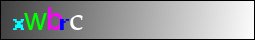

1/1 [==============================] - 0s 43ms/step
Predicted Text: xw5rc




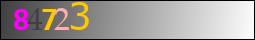

1/1 [==============================] - 0s 45ms/step
Predicted Text: 84723




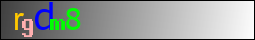

1/1 [==============================] - 0s 54ms/step
Predicted Text: rgdn8




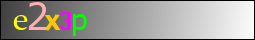

1/1 [==============================] - 0s 60ms/step
Predicted Text: e2xap




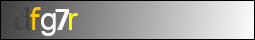

1/1 [==============================] - 0s 52ms/step
Predicted Text: dfg7r




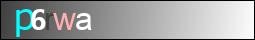

1/1 [==============================] - 0s 55ms/step
Predicted Text: p6rwa




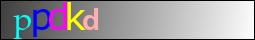

1/1 [==============================] - 0s 54ms/step
Predicted Text: ppdkd




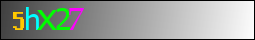

1/1 [==============================] - 0s 52ms/step
Predicted Text: 5hx27




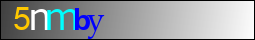

1/1 [==============================] - 0s 72ms/step
Predicted Text: 5nmby




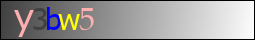

1/1 [==============================] - 0s 62ms/step
Predicted Text: y3bw5




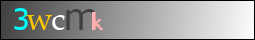

1/1 [==============================] - 0s 55ms/step
Predicted Text: 3wcmx




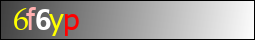

1/1 [==============================] - 0s 56ms/step
Predicted Text: 6f6yp




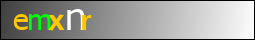

1/1 [==============================] - 0s 57ms/step
Predicted Text: emxnr




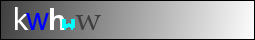

1/1 [==============================] - 0s 51ms/step
Predicted Text: kwhww




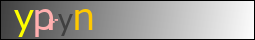

1/1 [==============================] - 0s 63ms/step
Predicted Text: ypryn




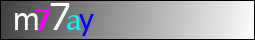

1/1 [==============================] - 0s 60ms/step
Predicted Text: m77ay




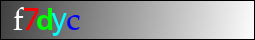

1/1 [==============================] - 0s 51ms/step
Predicted Text: f7dyc




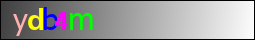

1/1 [==============================] - 0s 56ms/step
Predicted Text: ydbxm




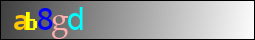

1/1 [==============================] - 0s 55ms/step
Predicted Text: ab8gd




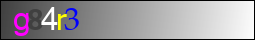

1/1 [==============================] - 0s 53ms/step
Predicted Text: g84r3




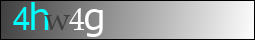

1/1 [==============================] - 0s 52ms/step
Predicted Text: 4hw4g




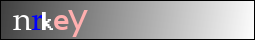

1/1 [==============================] - 0s 52ms/step
Predicted Text: nrkey




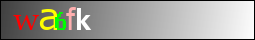

1/1 [==============================] - 0s 59ms/step
Predicted Text: wa6fk




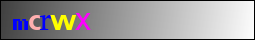

1/1 [==============================] - 0s 48ms/step
Predicted Text: mcrwx




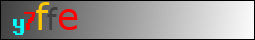

1/1 [==============================] - 0s 77ms/step
Predicted Text: yfffe




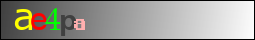

1/1 [==============================] - 0s 94ms/step
Predicted Text: ae4pa




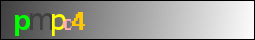

1/1 [==============================] - 0s 88ms/step
Predicted Text: pmpe4




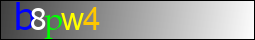

1/1 [==============================] - 0s 93ms/step
Predicted Text: b8pw4




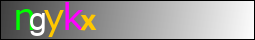

1/1 [==============================] - 0s 85ms/step
Predicted Text: ngykx




In [18]:
# Get the current directory
current_dir = os.getcwd()

# Get a list of all .png files in the current directory
png_files = glob.glob(os.path.join(current_dir, '*.png'))

# Iterate through the .png files
for file in png_files:
    # Open the image file
    image = Image.open(file)

    # Display the image
    display(image)
    predict_image_captcha(file)
    print('\n')